# Average Hamiltonian Theory

_Will Kaufman, 2021_

Trying to calculate different orders of approximation for the average Hamiltonian of a given pulse sequence.

## TODO

- [ ] Establish timing for pulse sequences, use common timing
- [ ] Calculate full unitary of pulse sequence, then compare fidelities with that
- [ ] Try out longer pulse sequences, see if terms can be calculated quickly
- [ ] Think of other ways to evaluate/differentiate pulse sequences (geometric argument, others?)

In [132]:
import numpy as np
import qutip as qt
import sys
import os
from functools import lru_cache
import importlib

In [3]:
sys.path.append('..')

In [4]:
import pulse_sequences as ps

In [133]:
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

The system Hamiltonian is scaled using arbitrary units, where the time and energy scales are normalized to the chemical shift strength.

In [138]:
Hsys, chemical_shifts, dipolar_matrix = ps.get_Hsys(N=3, return_all=True)

In [140]:
chemical_shifts, dipolar_matrix

(array([ 3.64581215, -8.67074416, -0.1021764 ]),
 array([[ 0.01057902, -0.07468904, -0.07848702],
        [ 0.02415493,  0.00740938, -0.06729908],
        [-0.05110514, -0.05296717,  0.07552711]]))

In [141]:
X, Y, Z = ps.get_collective_spin(N=3)

In [142]:
interaction_frames = [
    qt.identity(X.dims[0]),
    qt.propagator(X, np.pi / 2),
    qt.propagator(-X, np.pi / 2),
    qt.propagator(Y, np.pi / 2),
    qt.propagator(-Y, np.pi / 2),
] 

In [188]:
frame = qt.identity(Hsys.dims[0])
H_list = []
tau = [0.01] * 6  # spacing between pulses, scaled according to chemical shift strength
# NOTE: tau * ||Hsys|| << 1 should be satisfied for Magnus expansion to converge

In [189]:
for p in ps.whh4:
    frame = interaction_frames[p] * frame
    H_list.append(frame.dag() * Hsys * frame)

In [190]:
def get_H0(H_list, tau, length):
    H0 = None
    for i, t in enumerate(tau):
        H0 = H_list[i] * t if H0 is None else H0 + H_list[i] * t
    return H0 / sum(tau)

In [191]:
H0 = get_H0(H_list, tau, 6)

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

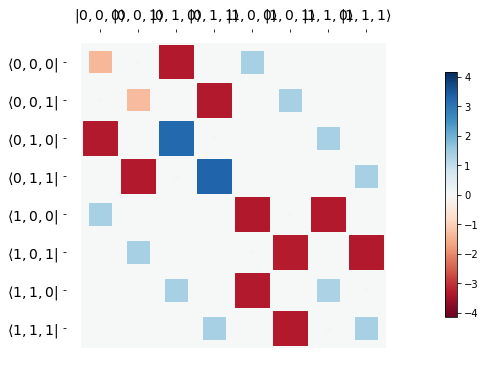

In [192]:
qt.hinton(H0)

In [193]:
N = 3
H0_AHT = sum([
    qt.tensor(
        [qt.identity(2)] * i
        + [1/3
           * chemical_shifts[i]
           * (qt.sigmax()
              + qt.sigmay()
              + qt.sigmaz())]
        + [qt.identity(2)] * (N - i - 1)
    ) for i in range(N)
])

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

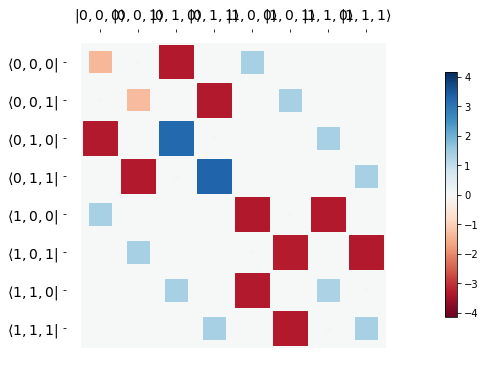

In [194]:
qt.hinton(H0_AHT)

In [195]:
@lru_cache(None)
def comm(a, b):
    A = H_list[a]
    B = H_list[b]
    result = A*B - B*A
    H_list.append(result)
    return len(H_list) - 1

In [196]:
def get_H1(H_list, tau, length):
    """
    Args:
        H_list (list): List of Qobj representing toggled Hamiltonians or commutators
        tau (list): Time delays after each pulse
        length: Number of pulses in sequence
    """
    H1 = None
    for i in range(length):
        for j in range(i):
            index = comm(i, j)
            H1_new = H_list[index] * tau[i] * tau[j]
            H1 = H1_new if H1 is None else H1 + H1_new
    return 1/(2j * sum(tau)) * H1

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

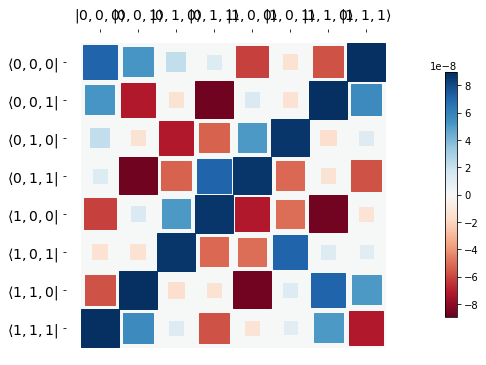

In [199]:
H1 = get_H1(H_list, tau, 6)
qt.hinton(H1)

In [200]:
def get_H2(H_list, tau, length):
    H2 = None
    for i in range(length):
        for j in range(i):
            for k in range(j):
                index1 = comm(i, comm(j, k))
                index2 = comm(comm(i, j), k)
                H2_new = (H_list[index1] + H_list[index2]) * tau[i] * tau[j] * tau[k]
                H2 = H2_new if H2 is None else H2 + H2_new
    return -1/(6 * sum(tau)) * H2

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

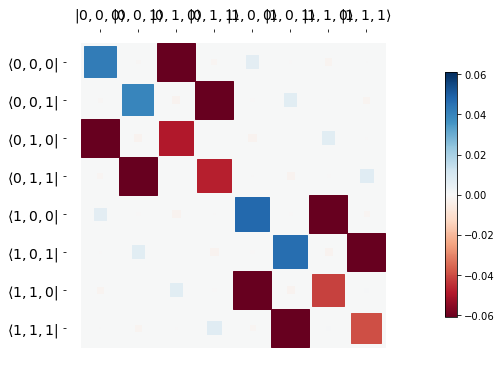

In [201]:
H2 = get_H2(H_list, tau, 6)
qt.hinton(H2)

In [202]:
def get_H3(H_list, tau, length):
    H3 = None
    for i in range(length):
        for j in range(i):
            for k in range(j):
                for l in range(k):
                    index1 = comm(comm(comm(i, j), k), l)
                    index2 = comm(i, comm(comm(j, k), l))
                    index3 = comm(i, comm(j, comm(k, l)))
                    index4 = comm(j, comm(k, comm(l, i)))
                    H3_new = (H_list[index1] + H_list[index2]
                              + H_list[index3] + H_list[index4]) * (
                        tau[i] * tau[j] * tau[k] * tau[l]
                    )
                    H3 = H3_new if H3 is None else H3 + H3_new
    return -1/(12j * sum(tau)) * H3

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/qutip/visualization.py:331: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(ylabels)))


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

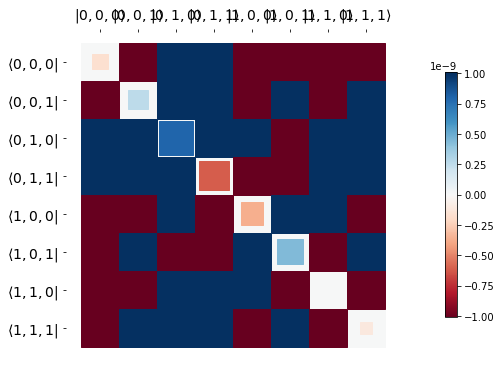

In [203]:
H3 = get_H3(H_list, tau, 6)
qt.hinton(H3)

In [ ]:
# def get_H4(H_list, tau, length):
#     H4 = None
#     for i in range(length):
#         for j in range(i):
#             for k in range(j):
#                 for l in range(k):
#                     for m in range(l):
#                         # TODO modify for 4th order term
#                         index1 = comm(comm(comm(i, j), k), l)
#                         index2 = comm(i, comm(comm(j, k), l))
#                         index3 = comm(i, comm(j, comm(k, l)))
#                         index4 = comm(j, comm(k, comm(l, i)))
#                         H3_new = (H_list[index1] + H_list[index2]
#                                   + H_list[index3] + H_list[index4]) * (
#                             tau[i] * tau[j] * tau[k] * tau[l]
#                         )
#                         H3 = H3_new if H3 is None else H3 + H3_new
#     throw NotImplementedError('This is not implemented yet!')
# #     return -1/(12j * sum(tau)) * H3

Compare fidelity of different orders of Magnus expansion

In [222]:
fidelity = qt.metrics.average_gate_fidelity(
    (-1j * H0).expm(),
    (-1j * (H0 + H1 + H2)).expm())
-np.log10(1 - fidelity + 1e-200)

3.1517152315340646